In [1]:
import tifffile
import matplotlib.pyplot as plt
import numpy as np

# Dimensional reduction

Consider a generic situation with in which many parameters are measured in many instances, time points, or replicas of a system resulting in dataset 
$$
x_{ij}\quad\mathrm{with}\quad i\in [1, \ldots, n]\,\mathrm{datapoints\,of}\, j\in [1, \ldots, p]\,\mathrm{quantities}
$$
If the difference quantities are completely independent, there is no point analyzing them together. But in many scenarios, the variables depend on each other in some way and these dependencies might be what is interesting in these data. Here, we want to explore general ways to analyze such data. 


## Compositional data

In many cases, the observed data is a sum of different components. Say you measured light emission from fluourescent proteins at different wave length. In this case, your measurements of one sample (or pixel) would be a vector of emissions, which different fluorescent proteins contribute to different degree. Data $x_{ij}$ could therefore be expressed as the signal from a sum of different fluorophores present with concentration $c_{ik}$ each having an emission spectrum $y_{kj}$.
$$
x_{ij} = \sum_k c_{ik}y_{kj}
$$
This setting is illustrated in the composite figure below
![poissonNMF](figures/NMF.png)



In this case, we might be primarily interested in the $c_{ik}$, i.e. the concentration of various dyes across the sample. And if we knew the spectra $y_{kj}$, this would of course be a well posed problem that we can solve by solving the linear system of equation or calculating the posterior of the concentrations given the linear system as the model of the mean. But if we don't know the spectra, the problem is degenerate. 

Any invertible matrix $S_{ij}$ with $S_{mk}S^{-1}_{kn} = \delta_{mn}$ could be stuck in between the concentrations and the spectra:
$$
x_{ij} = \sum_k c_{ik}y_{kj} = \sum_{k,m,n} c_{im}S_{mk}S^{-1}_{kn} y_{nj}
$$
and $c'_{ik} = \sum_m c_{im}S_{mk}$ or $y_{kj} =\sum_n S^{-1}_{kn} y_{nj}$ would be an equivalent solution. 

In general, such matrix factorizations are not unique and require additional constraints and conditions. 


### Non-negative matrix factorization
The above example of mixtures of fluorescence from different sources naturally requires that the $c_{ik}$ and the $y_{kj}$ are positive (or at least not negative). Factorization of such data into non-negative components is known as [non-negative matrix factorization (NMF)](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization). These concepts were developed in the 1990s.

While the non-negativity constraint does not in general determine the solution uniquely, it does greatly constrain the factorization. 

#### Multiplicative update rules
Lee and Seung published an [influential paper in 1999](https://www.nature.com/articles/44565) describing a simple and elegant way to perform such negative matrix factorization. The key idea is that the learning rate of gradient descent can be chosen such that the update rules are multiplicative and thus preserve the sign. 

The key idea is to minimize an objective function like
$$
\chi^2 = \frac{1}{2}\sum_{ij} (x_{ij} - \sum_k c_{ik}y_{kj})^2
$$
subject to the contraint that $c$ and $y$ are positive. Similar schemes can be devised for objective functions that are the log-likelihood of a Poisson distributed variables with mean $\sum_k c_{ik}{kj}$, as would for example be expected for photons collected by a microscope.

The gradient of the objective function with respect to $c$ is 
$$
\frac{\partial \chi^2}{\partial c_{nm}} = -\sum_{ij} (x_{ij} - \sum_k c_{ik}y_{kj})\sum_l y_{lj}\delta_{in}\delta_{lm} = -\sum_{j} (x_{nj} - \sum_k c_{nk}y_{kj})y_{mj}
$$
This suggests that we should be updated $c_{nm}$ as 
$$
c_{nm} \leftarrow c_{nm} + \eta_{nm}   \sum_{j} (x_{nj} - \sum_k c_{nk}y_{kj})y_{mj}
$$
Setting the learning rate to $\eta_{nm}= c_{nm}/ \sum_{kj} c_{nk}y_{kj} y_{mj}$, the 
$$
c_{nm} \leftarrow c_{nm} + \frac{c_nm}{\sum_{kj} c_{nk}y_{kj} y_{jm}} \sum_{j} (x_{nj} - \sum_k c_{nk}y_{kj})y_{mj}= c_{nm} \frac{\sum_{j} x_{nj}y_{mj}}{\sum_{kj} c_{nk}y_{kj} y_{mj}}
$$
This update rule compares the measurement $x_{nj}$ to the predicted value $\sum_{k} c_{nk}y_{kj}$, both projected onto the spectrum $y_{mj}$, to each other and rescales $c_{nm}$ by that ratio.

An analogous formula for the spectra reads
$$
y_{nm} \leftarrow y_{nm} \frac{\sum_{j} x_{jm}c_{jn}}{\sum_{kj} c_{jk}y_{km} c_{jn}}
$$




read image with dimensions (8, 976, 976)
Dark count [206 206 202 204 209 198 208 189]


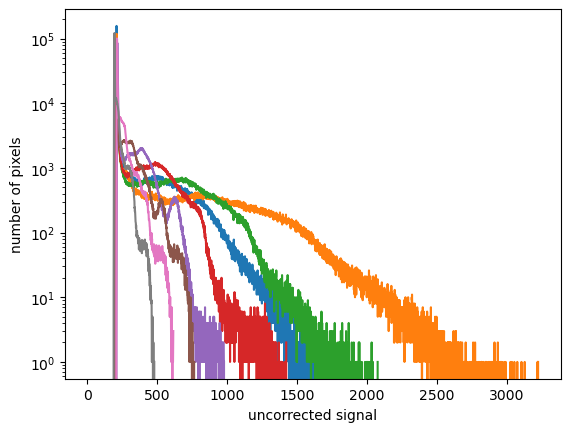

In [2]:
# pip install tifffiled
img_stack = tifffile.imread('data/3dyeZeiss.lsm')
original_shape = img_stack.shape
p, w, h = original_shape
print("read image with dimensions", original_shape)
data = img_stack.reshape(p, w*h).T
for i in range(p):
    y = np.bincount(data[:,i])
    plt.plot(np.arange(len(y)),y)
plt.yscale('log')
plt.xlabel('uncorrected signal')
plt.ylabel('number of pixels')
dark_count = np.min(data, axis=0)
data_corrected = data-dark_count
print("Dark count", dark_count)

initial state, cost: 4.000e+11
iteration 0, cost: 8.068e+09
iteration 10, cost: 1.145e+09
iteration 20, cost: 4.546e+08
iteration 30, cost: 3.470e+08
iteration 40, cost: 3.223e+08
iteration 50, cost: 3.084e+08
iteration 60, cost: 2.978e+08
iteration 70, cost: 2.898e+08
iteration 80, cost: 2.840e+08
iteration 90, cost: 2.802e+08


Text(0, 0.5, 'emissions')

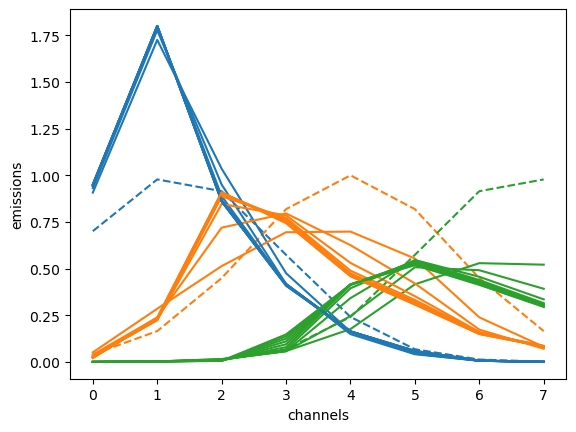

In [3]:
def NMF_update(X, C, Y):
    C = C*X.dot(Y.T)/C.dot(Y).dot(Y.T)
    Y = Y*(C.T).dot(X)/(C.T).dot(C.dot(Y))
    return C,Y

n = w*h
k = 3
C = np.random.random(size=(n,k)) + 50
channels = np.arange(p)
Y = np.array([np.exp(-0.2*((i+0.5)*p/k - channels)**2) for i in range(k)])
print(f"initial state, cost: {np.sum((data_corrected - C.dot(Y))**2):1.3e}")
n_iter = 100
for j in range(k):
    plt.plot(Y[j], c=f"C{j}", ls='--')
for i in range(n_iter):
    C, Y = NMF_update(data_corrected, C, Y)
    if i%10==0:
        print(f"iteration {i}, cost: {np.sum((data_corrected - C.dot(Y))**2):1.3e}")
        for j in range(k):
            plt.plot(Y[j], c=f"C{j}")
plt.xlabel('channels')
plt.ylabel('emissions')

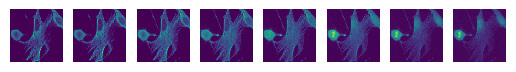

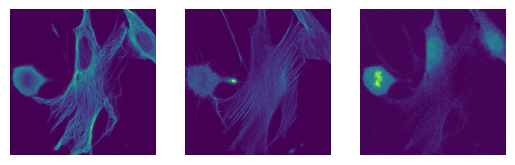

In [4]:
fig, axs = plt.subplots(1,p)
for i in range(p):
    axs[i].matshow(img_stack[i])
    axs[i].set_axis_off()

fig, axs = plt.subplots(1,k)
for i in range(k):
    axs[i].matshow(C[:,i].reshape(h,w))
    axs[i].set_axis_off()

If the noise in the data stem from Poisson fluctuations due to limit numbers of photons that are collected from each pixel, we expect that the signal at pixels with identical concentration fluctuates with a variance proportional to the mean. But we don't know the signal $p$ corresponding to that of a single photon. In terms of the average number of photons $\bar{m}$, the mean and variance at a pixel are then given by 
$$
\langle x_{ij} \rangle = p \bar{m}_{ij} \quad \mathrm{and} \quad \langle \delta x^2_{ij} \rangle = p^2\bar{m}_{ij}
$$
If the actual concentrations vary only slowly in space, we expect neighboring pixels to have similar values and we can estimate the average signal $\frac{x_{ij} + x_{i+1,j}}{2}$ and the variance $(x_{ij} - x_{i+1,j})^2$. Binning pixel pairs with the similar $\frac{x_{ij} + x_{i+1,j}}{2}$ and calculating the variance within these bins allows us to estimate the single photon signal $p$ by linear regression. 


Channel 0: p=2.30
Channel 1: p=3.09
Channel 2: p=2.35
Channel 3: p=1.55
Channel 4: p=1.35
Channel 5: p=1.30
Channel 6: p=1.47
Channel 7: p=1.10


Text(0.5, 0, 'average signal')

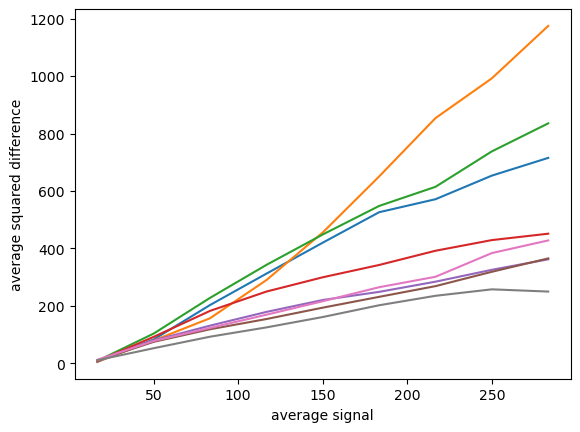

In [5]:
# Poisson nature of signal
signal_bins = np.linspace(0,300,10)
pixel_variation = []
for i in range(p):
    dp = img_stack[i][1:] - img_stack[i][:-1]
    mp = 0.5*(img_stack[i][1:] + img_stack[i][:-1]) - dark_count[i]
    pixel_variation.append([np.mean(dp[(mp>=signal_bins[j]) & (mp<signal_bins[j+1])]**2) for j in range(len(signal_bins)-1)])
    plt.plot(0.5*(signal_bins[1:] + signal_bins[:-1]), pixel_variation[-1], c=f'C{i}')
    print(f"Channel {i}: p={(dp**2).sum()/mp.sum():1.2f}")
plt.ylabel('average squared difference')
plt.xlabel('average signal')


The approximate linear relationship confirms that noise is approximately Poisson, and that single photon signal is of order one. We should not expect an precise estimate from this rough analysis -- but this serves as a useful consistency check on the nature of the noise in the data. Notably, we have assumed an intensity independent noise in the matrix factorization above -- so this is something we might want to address!!

### Principal component analysis
PCA is probably the most important and well known method to decompose data into a smaller number of components.
The common use case is to account for the fact that measurements of many quantities are strongly correlated. 
A dataset where this is readily appreciated are weather recordings, as we explore here for [the 2024 data from Basel](https://data.geo.admin.ch/browser/index.html#/collections/ch.meteoschweiz.ogd-smn?.language=en):


In [6]:
import pandas as pd

d = pd.read_csv('data/Basel_weather_2024.csv', sep=';')
d.head()

,station_abbr,reference_timestamp,tre200h0,tre200hn,tre200hx,tre005h0,tre005hn,ure200h0,pva200h0,tde200h0,...,fve010h0,rre150h0,htoauths,gre000h0,oli000h0,olo000h0,osr000h0,ods000h0,sre000h0,erefaoh0
0,BAS,01.01.2024 00:00,5.5,4.7,6.4,2.0,0.6,71.6,6.4,0.8,...,NaN,0.0,0.0,0,269,NaN,NaN,1.0,0,0.010
1,BAS,01.01.2024 01:00,6.6,6.4,6.9,5.3,5.0,68.3,6.6,1.2,...,NaN,0.0,0.0,0,304,NaN,NaN,1.0,0,0.025
2,BAS,01.01.2024 02:00,5.7,5.3,6.4,4.2,3.6,82.2,7.5,2.8,...,NaN,1.4,0.0,0,321,NaN,NaN,2.0,0,0.012
3,BAS,01.01.2024 03:00,5.7,5.3,6.1,3.7,3.3,79.4,7.3,2.4,...,NaN,0.0,0.0,0,298,NaN,NaN,1.0,0,0.014
4,BAS,01.01.2024 04:00,5.7,5.3,6.0,3.2,2.6,74.9,6.9,1.6,...,NaN,0.0,0.0,0,286,NaN,NaN,1.0,0,0.013


Correlation matrix


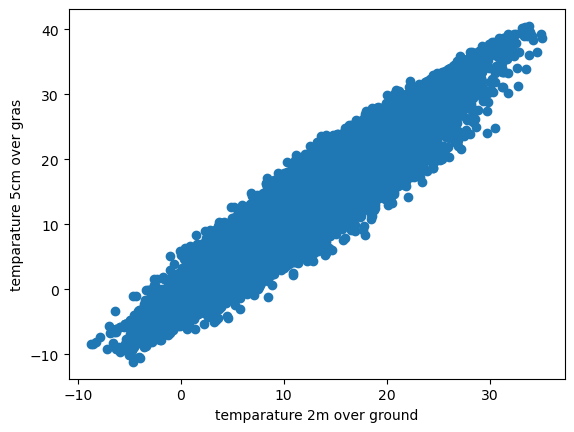

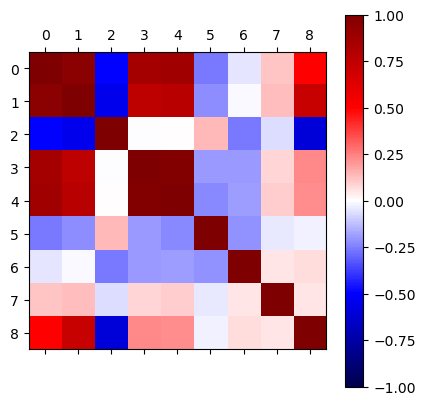

In [7]:
plt.scatter(d.tre200h0, d.tre005h0)
plt.xlabel('temparature 2m over ground')
plt.ylabel('temparature 5cm over gras')

# Make a subset of interpretable columns
# temperate 2m, temperate 5cm, humidity, dampfdruck, dewpoint, pressure, wind speek, wind direction, radiation
d_subset = d.loc[:,['tre200h0', 'tre005h0', 'ure200h0', 'pva200h0', 'tde200h0', 'prestah0', 'fkl010h0', 'dkl010h0','gre000h0']]
print("Correlation matrix")
plt.matshow(np.corrcoef(d_subset.T), vmin=-1, vmax=1, cmap='seismic');
plt.colorbar();

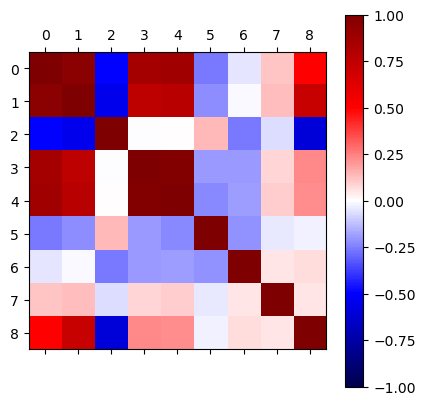

In [8]:
# Center and standardize the matrix
d_subset -= d_subset.mean(axis=0)
variation = d_subset.std(axis=0)
d_subset /= variation
plt.matshow(d_subset.T.dot(d_subset)/len(d), vmin=-1, vmax=1, cmap='seismic');
plt.colorbar()

Text(0, 0.5, 'unexplained variance')

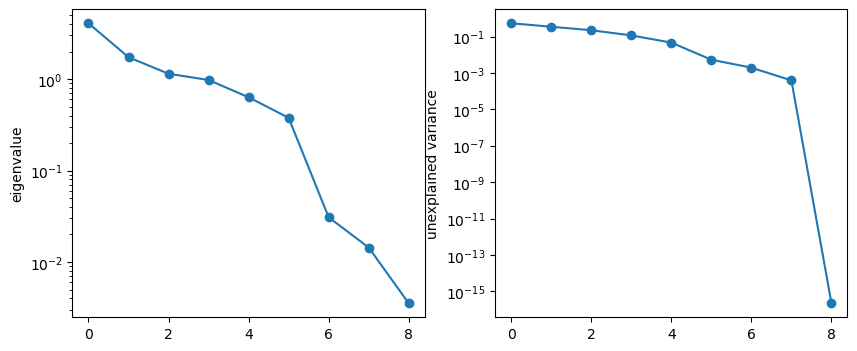

In [9]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
evs = np.array(sorted(np.linalg.eig(d_subset.T.dot(d_subset)/len(d))[0], reverse=True))
axs[0].plot(evs, 'o-')
axs[0].set_ylabel('eigenvalue')
axs[0].set_yscale('log')
total_var = np.sum(evs)
axs[1].plot(1-np.cumsum(evs)/total_var, 'o-')
axs[1].set_yscale('log')
axs[1].set_ylabel('unexplained variance')


In PCA, we successively determine the directions in the $p$-dimensional data space that explain most of the variation in the data (after normalization). The geometric picture is that the covariance of the data is described by a $p$-dimensional ellipsoid. The first principal direction is that with greatest variation and so forth. Successive principal directions are orthogonal.

The degeneracy of matrix factorization that we discussed above is solved by the orthogonality constraint. A set of PCs also captures the maximal amount of variation that can be captured in a linear subspace of that dimension. 


### Singular value decomposition

PCA can be cast into a matrix factorization problem known as [singular value decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition). Any complex rectangular matrix $X$ with shape $n\times p$ can be written as 
$$
X = U \Sigma V^*
$$
where $U$ is a $n\times n$ unitary matrix (i.e. the complex conjugate transpose is its inverse), $V$ is a $p\times p$ unitary matrix, and $\Sigma$ is a rectangular $n\times p$ matrix with diagonal elements only. The number of non-zero diagonal elements is equal to the rank of the matrix $X$ and by necessity at most $n$ or $p$. 

For real matrices $X$, $U$ and $V$ are orthogonal matrices. 

It is instructive to view singular value decomposition as the sum of contributions of the individual singular values. 
$$
X_{ij} = \sum_k u_{ik}\sigma_{kk} v_{jk}
$$
If the $\sigma_{kk}$ are ordered by size, the sum can be restricted to the first few components to obtain a low-rank approximation of the data. The decomposition then amounts to 

 - a rotation into the space spanned by these first principal directions
 - scaling within this subspace
 - rotation back into the space of the data

We can immediately look at our weather example in terms of a decomposition into these components.

In [10]:
# this will return a matrix U, the diagonal of Sigma, and V
U,S,V = np.linalg.svd(d_subset)

Shape of the matrices: (11352, 11352) (9,) (9, 9)


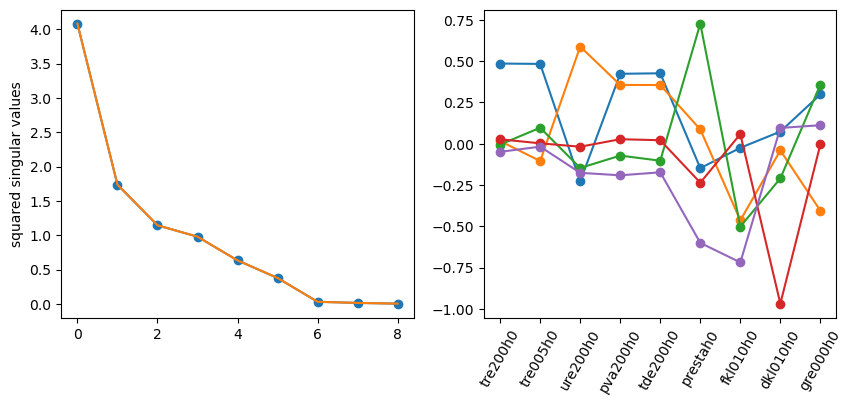

In [11]:
print("Shape of the matrices:", U.shape, S.shape, V.shape)
fig, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].plot(S**2/len(U), '-o')
axs[0].plot(evs)
axs[0].set_ylabel('squared singular values')

for i in range(5):
    axs[1].plot(V[i], '-o')

axs[1].set_xticks(np.arange(len(S)), d_subset.columns, rotation=60);

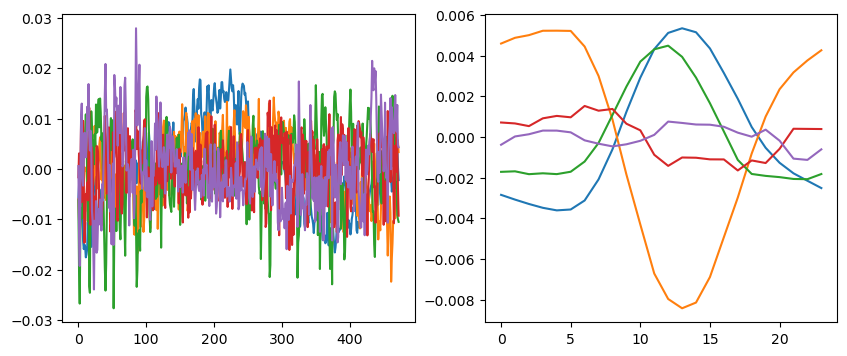

In [12]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
for i in range(5):
    axs[0].plot(np.array([U[j::24,i] for j in range(24)]).mean(axis=0))
    axs[1].plot(np.array([U[j::24,i] for j in range(24)]).mean(axis=1))



### Correspondance to the eigenvalues and eigenvectors of the covariance matrix

We already showed that the singular values of $X$ are the square roots of eigenvalues of the covariance matrix $\frac{1}{n}X^T X$. This is direct consequence of the definition of SVD
$$
X^T X = (V D U^T ) (U D V^T) = V D^2 V^T
$$
Similarly, the rows of $V$ are the eigenvectors of $X^T X$ since $V^T V = I$.




### Noise vs signal in dimensional reduction
Whenever performing dimensional reduction, the natural questions arise
- how many dimensions to keep
- what is the meaning of the dimensions we keep

To get some insight into this, let's consider the eigenvalue spectrum of the covariance matrix of a random $n\times p$ matrix.



Text(0.5, 0, 'eigenvalue spacing')

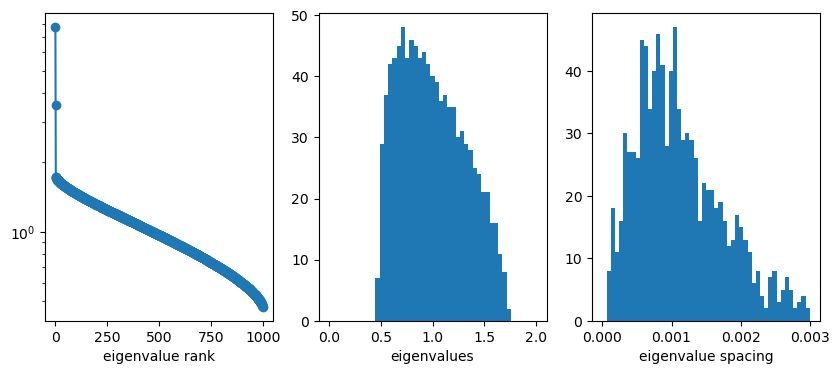

In [13]:
n=10000
p=1000

d = np.random.randn(2,p)
X = np.random.randn(n,p) + 8/np.sqrt(n)*np.outer(np.random.randn(n),d[0]) + 5/np.sqrt(n)*np.outer(np.random.randn(n),d[1])

ev, evec = np.linalg.eig(X.T.dot(X)/n);
fig, axs = plt.subplots(1,3, figsize=(10,4))
evs = np.array(sorted(ev, reverse=True))
axs[0].plot(evs, '-o')
axs[0].set_yscale('log')
axs[0].set_xlabel('eigenvalue rank')
axs[1].hist(evs, bins=np.linspace(0,2,50));
axs[1].set_xlabel('eigenvalues')
axs[2].hist(evs[2:-1]-evs[3:], bins=np.linspace(0, 0.003, 51));
axs[2].set_xlabel('eigenvalue spacing')


There are several remarkable patterns here:
 - the two 'extra' modes we added clearly stick out
 - the remaining eigenvalues are curiously clustered in their distribution
 - the difference between successive eigenvalues is peaked away from zero (unlike what you's expect from a random spacing)

To get an appreciation for these observations, we need to take a short detour into random matrix theory. 

### Detour: Random matrix theory

When characterizing energy levels of systems with many interacting components (for example nuclei consisting of many protons and neutrons), physicists notices a surprising regularity in the spacing of these energy levels. In quantum mechanics, these energy levels correspond to eigenvalues of the Hamiltonian.
While these systems were too complicated for direct calculation, Eugene Wigner noticed that many of their properties could be described by eigenvalues of random matrices. 

The simplest such "ensemble" or random matrices is the Gaussian Orthogonal Ensemble defined as symmetric matrices $h_{ij}$ where each element is distributed as a Gaussian with a variance that scales as $N^{-1}$
$$
p(H) \sim e^{-\frac{N}{4}\sum_{ij} H_{ij}^2} = e^{-\frac{N}{4}\sum_{ij} H_{ij}H_{ij}} =  e^{-\frac{N}{4}tr(H^2)}
$$
where we used that the trace $tr(H^2) = \sum_i \left( H^2 \right)_{ii} = \sum_i \sum_j h_{ij} h_{ji} =  \sum_{ij} h_{ij}^2$. Formulating this using the trace makes it obvious that this ensemble is independent of the choice of basis. 

With this scaling, elements on the diagonal have variance $2/n$ and the remaining $n(n-1)/2$ have variance $1/n$.


In [14]:
def goe_matrix(n):
    tmp = np.random.randn(n,n)
    return (tmp+tmp.T)/np.sqrt(2*n)

n=100
H = goe_matrix(n)
print(f"Variance on diagonal: {np.var(H.diagonal())*n}")
# the n diagonal elements are a minor perturbation to the n(n-1)/2 total elements. 
print(f"Global Variance on diagonal: {np.var(H)*n}")


Variance on diagonal: 2.1872892411569205
Global Variance on diagonal: 0.9934825656665449


For such Gaussian ensembles, Wigner shows that the distribution of eigenvalues follows a simple distribution known as Wigner's semi-circle law. The basic idea to proving this is outlined below and starts with expectation values of the trace of powers of the matrix $H$.
$$
\langle \frac{1}{N} tr(H^k)\rangle = \langle \frac{1}{N} \sum_{i=1}^n \lambda_i^k\rangle = \langle \lambda^k \rangle = \int d\lambda \, p(\lambda)\lambda^k
$$
where the second step uses the fact that (i) a symmetric matrix can be diagonalized, and (ii) the eigenvalues of a matrix power are the powers of the eigenvalues. Hence calculating the expectation value of the trace of powers of $H$ gives the moments of the eigenvalue distribution. 
The terms on the very left look like 
$$
tr(H^{k}) = \sum_{i_1, i_2, i_3, \dots i_k} = H_{i_1i_2}H_{i_2i_3}\ldots H_{i_{k}i_1}
$$
Ever odd moment will vanish because there is at least one independent term that averages to 0. Even moments can be tackled using various ideas from combinatories. The bottom line is that the moments are the same as those of a distribution with the shape of a semi-circle. 

In [15]:
n=1000
H = goe_matrix(n)
evs_H = np.array(sorted(np.linalg.eig(H)[0]));


Text(0.5, 0, 'eigenvalues')

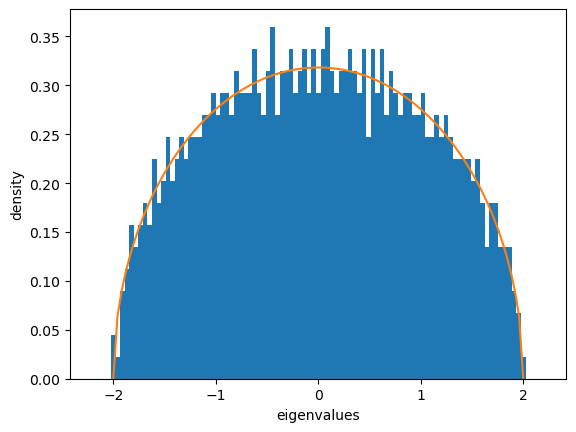

In [16]:
plt.hist(evs_H, bins=np.linspace(-2.2, 2.2, 100), density=True);
x=np.linspace(-2,2,101)
plt.plot(x, np.sqrt(4-x**2)/2/np.pi, label='Semi-circle')
plt.ylabel('density')
plt.xlabel('eigenvalues')

### Eigenvalue spectra of PCA
If you consider a $n\times p$ matrix $X$ where each element is an independent Gaussian random variable, elements of the $n^{-1} X^T X$ 
$$
n^{-1}\langle\sum_{k=1}^p x_{ik} x_{jk} \rangle = 
\begin{cases}
1 & i=j \\
0 & otherwise
\end{cases}
$$
The variance around these average is of order $\sqrt{n^{-1}}$. 

In contrast to the matrices $H$ discussed above, the diagonal elements of $n^{-1} X^T X$ vary around one. We therefore expect eigenvalues to be shifted away from zero. The remainder of the matrix, however, is random and it is symmetric such that we might hope that some ideas from above also apply to this type of matrices. And indeed they do. But there are correlations between elements that change the shape of the eigenvalue distribtution. 

This distribution is known as the Marchenko-Pastur distribution. In the limit of large matrixces, is depends on the ratio $p/n$ and has  diverging density at $0$ once $p\geq n$, corresponding to the null-space of the rank-deficient matrix  


/tmp/ipykernel_989399/3337113162.py:4: RuntimeWarning: invalid value encountered in divide
  return n/2/np.pi/p*np.sqrt(np.maximum(0.0,(l2-l)*(l-l1)))/l


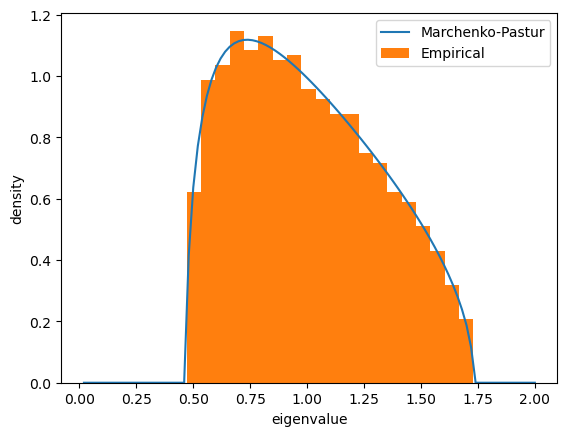

In [17]:
# comparing the results from above to the theoretical distribution
def marchenko_pastur(l, n,p):
    l1, l2 = (1+np.sqrt(p/n))**2, (1-np.sqrt(p/n))**2
    return n/2/np.pi/p*np.sqrt(np.maximum(0.0,(l2-l)*(l-l1)))/l

l=np.linspace(0,2,101)
n=10000 # value used above
plt.plot(l, marchenko_pastur(l, n,p), label='Marchenko-Pastur')
plt.hist(evs[2:], density=True, bins=20, label='Empirical')
plt.xlabel('eigenvalue')
plt.ylabel('density')
plt.legend()

The largest eigenvalues is expected to be $(1+\sqrt{p/n})^2$ larger than the average eigenvalue. Deviations from this indicate that there are non-trivial correlations in the data or that the data are not iid Gaussian random variables. In practice, nothing in biology is ever completely independent, nor exactly Gaussian. But nevertheless the random matrix theory gives a useful framework to interpret the spectrum of eigenvalues in high-dimensional data. 

The topic has attracted a lot of attention at the intersection of statistical physics of disordered system, applied probability theory, and finance. In particular, people have invested the distribution of the [largest eigenvalue of this distribution](https://en.wikipedia.org/wiki/Tracy%E2%80%93Widom_distribution). 
